### Importación de datos



In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


In [2]:
import unicodedata
# normalizar columnas
def normalize_colname(col: str) -> str:
    x = col.strip().lower()
    x = "".join(c for c in unicodedata.normalize("NFD", x) if unicodedata.category(c) != "Mn")
    x = x.replace(" ", "_")
    return x

In [3]:
for df, store in zip([tienda, tienda2, tienda3, tienda4], ["Tienda 1","Tienda 2","Tienda 3","Tienda 4"]):
    df.columns = [normalize_colname(c) for c in df.columns]
    df["tienda"] = store

In [4]:
# concatenar en un solo df
df_all = pd.concat([tienda, tienda2, tienda3, tienda4], ignore_index=True)

In [5]:
df_all.head()

,producto,categoria_del_producto,precio,costo_de_envio,fecha_de_compra,vendedor,lugar_de_compra,calificacion,metodo_de_pago,cantidad_de_cuotas,lat,lon,tienda
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175,Tienda 1
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359,Tienda 1
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444,Tienda 1
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250,Tienda 1
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359,Tienda 1


### Conocer conjunto de datos

In [6]:
print("Columnas actuales:", list(df_all.columns))

Columnas actuales: ['producto', 'categoria_del_producto', 'precio', 'costo_de_envio', 'fecha_de_compra', 'vendedor', 'lugar_de_compra', 'calificacion', 'metodo_de_pago', 'cantidad_de_cuotas', 'lat', 'lon', 'tienda']


In [7]:
def smart_pick(df, keys_like, avoid_like=None, prefer_like=None, max_uniques=200):
    avoid_like = avoid_like or []
    prefer_like = prefer_like or []
    cands = []
    for c in df.columns:
        name = c.lower()
        if any(k in name for k in keys_like) and not any(a in name for a in avoid_like):
            cands.append(c)
    # si hay varias, preferir las que contengan algún prefer_like
    if prefer_like:
        pref = [c for c in cands if any(p in c for p in prefer_like)]
        if pref:
            cands = pref
    # filtrar por cardinalidad razonable (evitar columnas tipo id únicas)
    scored = []
    for c in cands:
        try:
            u = df[c].nunique(dropna=True)
        except Exception:
            u = 10**9
        scored.append((u, c))
    # ordenar por cardinalidad asc (categoría típicamente no es enorme)
    scored.sort(key=lambda x: x[0])
    for u, c in scored:
        if u <= max_uniques:
            return c
    return scored[0][1] if scored else None

In [8]:
print("Forma:", df_all.shape)
print("\nColumnas:", list(df_all.columns))
print("\nNulos por columna:\n", df_all.isna().sum())

candidatos = {
    "precio":    ["precio", "price"],
    "categoria": ["categoria", "category"],
    "calif":     ["calificacion", "calificación", "rating"],
    "producto":  ["producto", "product", "nombre_producto"],
    "envio":     ["costo_envio", "envio", "shipping_cost"]
}

def pick_column(df, opciones):
    for opt in opciones:
        opt_norm = "".join(c for c in unicodedata.normalize("NFD", opt) if unicodedata.category(c) != "Mn")
        opt_norm = opt_norm.lower().replace(" ", "_")
        for col in df.columns:
            if col == opt_norm:
                return col
    return None

COL_PRECIO   = pick_column(df_all, candidatos["precio"])
COL_CAT      = pick_column(df_all, candidatos["categoria"])
COL_CALIF    = pick_column(df_all, candidatos["calif"])
COL_PROD     = pick_column(df_all, candidatos["producto"])
COL_ENVIO    = pick_column(df_all, candidatos["envio"])

print("\nColumnas detectadas:")
print("PRECIO   ->", COL_PRECIO)
print("CATEGORIA->", COL_CAT)
print("CALIF    ->", COL_CALIF)
print("PRODUCTO ->", COL_PROD)
print("ENVIO    ->", COL_ENVIO)

Forma: (9435, 13)

Columnas: ['producto', 'categoria_del_producto', 'precio', 'costo_de_envio', 'fecha_de_compra', 'vendedor', 'lugar_de_compra', 'calificacion', 'metodo_de_pago', 'cantidad_de_cuotas', 'lat', 'lon', 'tienda']

Nulos por columna:
 producto                  0
categoria_del_producto    0
precio                    0
costo_de_envio            0
fecha_de_compra           0
vendedor                  0
lugar_de_compra           0
calificacion              0
metodo_de_pago            0
cantidad_de_cuotas        0
lat                       0
lon                       0
tienda                    0
dtype: int64

Columnas detectadas:
PRECIO   -> precio
CATEGORIA-> None
CALIF    -> calificacion
PRODUCTO -> producto
ENVIO    -> None


In [9]:
# Intenta recuperar lo que falte:
try:
    COL_PRECIO
except NameError:
    COL_PRECIO = None
try:
    COL_CAT
except NameError:
    COL_CAT = None
try:
    COL_CALIF
except NameError:
    COL_CALIF = None
try:
    COL_PROD
except NameError:
    COL_PROD = None
try:
    COL_ENVIO
except NameError:
    COL_ENVIO = None

# Solo (re)asignar si están vacías
if COL_PRECIO is None:
    COL_PRECIO = smart_pick(df_all, keys_like=["precio","price","valor","monto"], prefer_like=["precio","price"])
if COL_CAT is None:
    COL_CAT    = smart_pick(df_all, keys_like=["categoria","category","categ","tipo"], prefer_like=["categoria","category"], max_uniques=100)
if COL_CALIF is None:
    COL_CALIF  = smart_pick(df_all, keys_like=["calificacion","calificacion","rating","rese","review","score"], prefer_like=["calificacion","rating"])
if COL_PROD is None:
    COL_PROD   = smart_pick(df_all, keys_like=["producto","product","nombre_producto","item","sku"], prefer_like=["producto","product"], max_uniques=10_000)
if COL_ENVIO is None:
    COL_ENVIO  = smart_pick(df_all, keys_like=["envio","envio","shipping","costo_envio","shipping_cost"], prefer_like=["costo_envio","shipping_cost"])

print("\nColumnas detectadas (revisadas):")
print("PRECIO   ->", COL_PRECIO)
print("CATEGORIA->", COL_CAT)
print("CALIF    ->", COL_CALIF)
print("PRODUCTO ->", COL_PROD)
print("ENVIO    ->", COL_ENVIO)


Columnas detectadas (revisadas):
PRECIO   -> precio
CATEGORIA-> categoria_del_producto
CALIF    -> calificacion
PRODUCTO -> producto
ENVIO    -> costo_de_envio


# 1. Análisis de facturación



In [10]:
import matplotlib.pyplot as plt

df_all[COL_PRECIO] = pd.to_numeric(df_all[COL_PRECIO], errors="coerce")

facturacion = df_all.groupby("tienda", as_index=False)[COL_PRECIO].sum()
facturacion.rename(columns={COL_PRECIO: "ingreso_total"}, inplace=True)
print(facturacion)


     tienda  ingreso_total
0  Tienda 1   1.150880e+09
1  Tienda 2   1.116344e+09
2  Tienda 3   1.098020e+09
3  Tienda 4   1.038376e+09


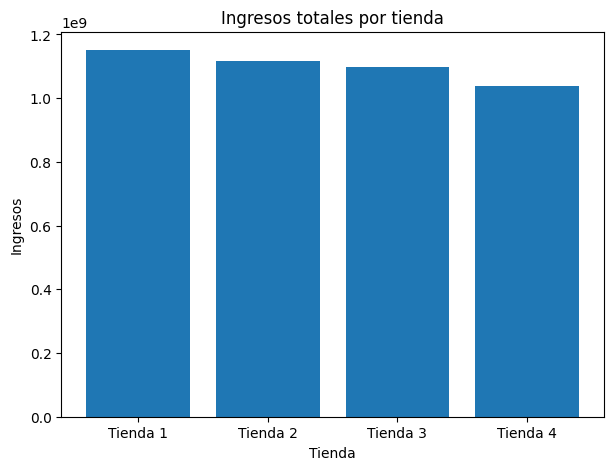

In [11]:
plt.figure(figsize=(7,5))
plt.bar(facturacion["tienda"], facturacion["ingreso_total"])
plt.title("Ingresos totales por tienda")
plt.xlabel("Tienda")
plt.ylabel("Ingresos")
plt.show()

# 2. Ventas por categoría

In [12]:
ventas_cat = (
    df_all.groupby(["tienda", COL_CAT])
    .size()
    .reset_index(name="ventas")
)

# Top 5 por tienda
top_cat = (
    ventas_cat
    .sort_values(["tienda","ventas"], ascending=[True,False])
    .groupby("tienda")
    .head(5)
)
print(top_cat)

# Global top 10
ventas_cat_total = (
    ventas_cat
    .groupby(COL_CAT)["ventas"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

      tienda categoria_del_producto  ventas
7   Tienda 1                Muebles     465
3   Tienda 1           Electrónicos     448
5   Tienda 1               Juguetes     324
2   Tienda 1      Electrodomésticos     312
1   Tienda 1   Deportes y diversión     284
15  Tienda 2                Muebles     442
11  Tienda 2           Electrónicos     422
13  Tienda 2               Juguetes     313
10  Tienda 2      Electrodomésticos     305
9   Tienda 2   Deportes y diversión     275
23  Tienda 3                Muebles     499
19  Tienda 3           Electrónicos     451
21  Tienda 3               Juguetes     315
18  Tienda 3      Electrodomésticos     278
17  Tienda 3   Deportes y diversión     277
31  Tienda 4                Muebles     480
27  Tienda 4           Electrónicos     451
29  Tienda 4               Juguetes     338
25  Tienda 4   Deportes y diversión     277
26  Tienda 4      Electrodomésticos     254


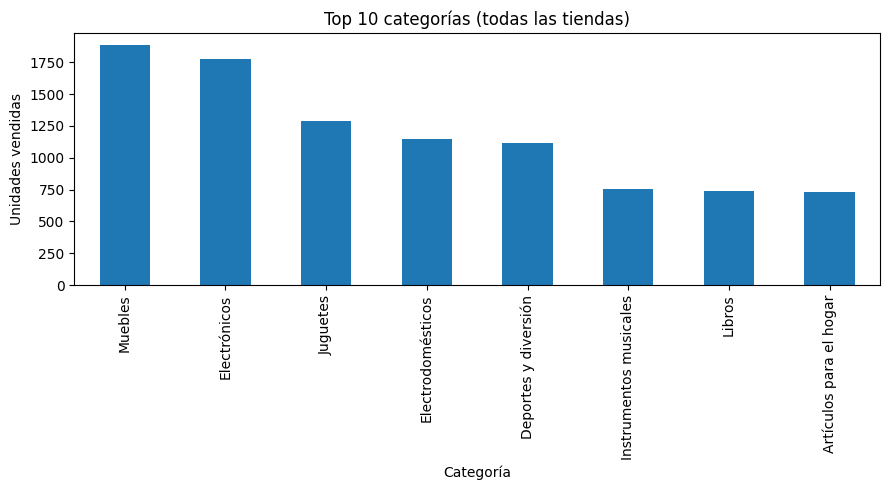

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
ventas_cat_total.plot(kind="bar")
plt.title("Top 10 categorías (todas las tiendas)")
plt.xlabel("Categoría")
plt.ylabel("Unidades vendidas")
plt.tight_layout()
plt.show()

# 3. Calificación promedio de la tienda


In [14]:
df_all[COL_CALIF] = pd.to_numeric(df_all[COL_CALIF], errors="coerce")

calif_prom = df_all.groupby("tienda")[COL_CALIF].mean().reset_index()
calif_prom.rename(columns={COL_CALIF:"calificacion_promedio"}, inplace=True)
print(calif_prom)

     tienda  calificacion_promedio
0  Tienda 1               3.976685
1  Tienda 2               4.037304
2  Tienda 3               4.048326
3  Tienda 4               3.995759


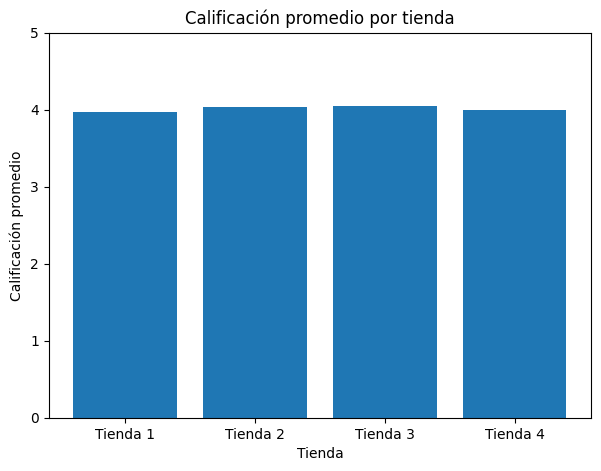

In [15]:
plt.figure(figsize=(7,5))
plt.bar(calif_prom["tienda"], calif_prom["calificacion_promedio"])
plt.title("Calificación promedio por tienda")
plt.xlabel("Tienda")
plt.ylabel("Calificación promedio")
plt.ylim(0,5)
plt.show()

# 4. Productos más y menos vendidos

In [16]:
ventas_prod = (
    df_all.groupby(["tienda", COL_PROD])
    .size()
    .reset_index(name="ventas")
)


Top 5 productos en Tienda 1:
       tienda          producto  ventas
1   Tienda 1           Armario      60
48  Tienda 1     TV LED UHD 4K      60
33  Tienda 1        Microondas      60
40  Tienda 1  Secadora de ropa      58
32  Tienda 1     Mesa de noche      56

Bottom 5 productos en Tienda 1:
       tienda                   producto  ventas
34  Tienda 1                    Mochila      39
38  Tienda 1                  Pandereta      36
37  Tienda 1            Olla de presión      35
13  Tienda 1               Celular ABXY      33
4   Tienda 1  Auriculares con micrófono      33


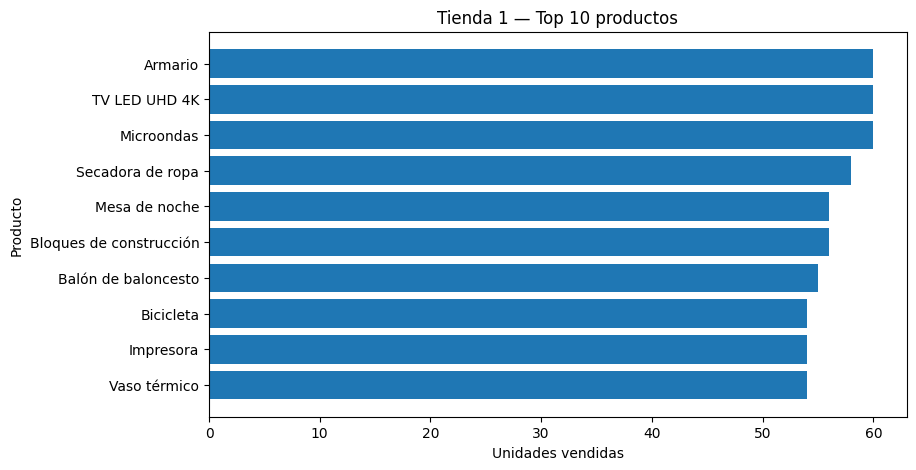


Top 5 productos en Tienda 2:
       tienda                   producto  ventas
75  Tienda 2  Iniciando en programación      65
84  Tienda 2                 Microondas      62
58  Tienda 2                    Batería      61
89  Tienda 2                  Pandereta      58
72  Tienda 2          Guitarra acústica      58

Bottom 5 productos en Tienda 2:
       tienda         producto  ventas
54  Tienda 2      Auriculares      37
95  Tienda 2           Sillón      35
74  Tienda 2        Impresora      34
82  Tienda 2  Mesa de comedor      34
77  Tienda 2    Juego de mesa      32


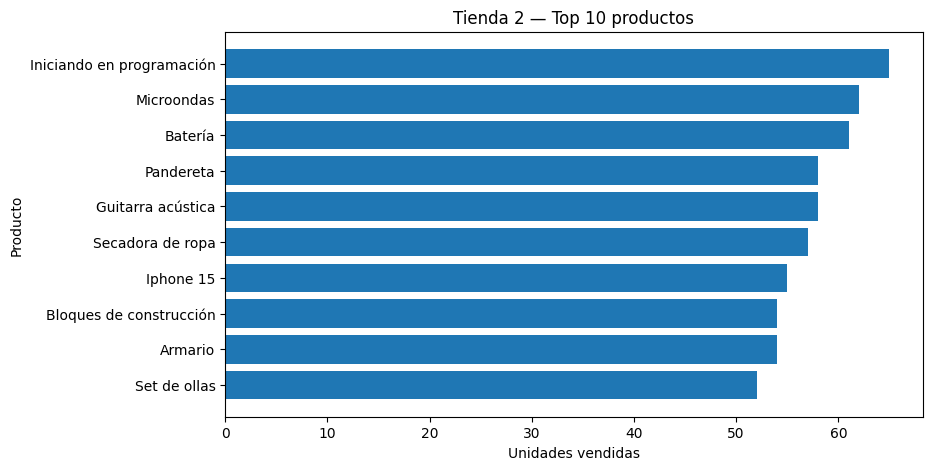


Top 5 productos en Tienda 3:
        tienda         producto  ventas
129  Tienda 3    Kit de bancas      57
133  Tienda 3  Mesa de comedor      56
113  Tienda 3        Cama king      56
143  Tienda 3     Set de ollas      55
134  Tienda 3    Mesa de noche      55

Bottom 5 productos en Tienda 3:
        tienda                 producto  ventas
124  Tienda 3       Guitarra eléctrica      38
136  Tienda 3                  Mochila      36
135  Tienda 3               Microondas      36
144  Tienda 3             Set de vasos      36
111  Tienda 3  Bloques de construcción      35


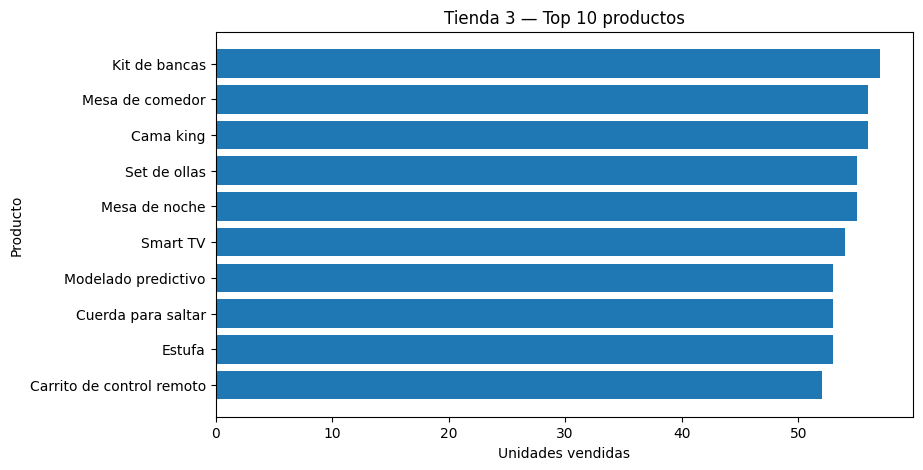


Top 5 productos en Tienda 4:
        tienda                   producto  ventas
163  Tienda 4                   Cama box      62
168  Tienda 4                 Cubertería      59
164  Tienda 4                  Cama king      56
171  Tienda 4    Dashboards con Power BI      56
165  Tienda 4  Carrito de control remoto      55

Bottom 5 productos en Tienda 4:
        tienda                     producto  ventas
167  Tienda 4  Ciencia de datos con Python      38
192  Tienda 4                 Refrigerador      38
174  Tienda 4            Guitarra acústica      37
154  Tienda 4                      Armario      34
175  Tienda 4           Guitarra eléctrica      33


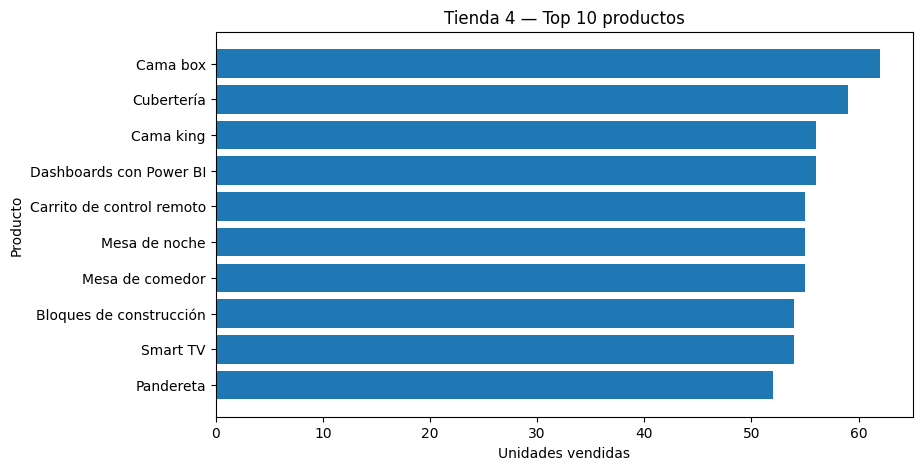

In [17]:
for tienda in ventas_prod["tienda"].unique():
    sub = ventas_prod[ventas_prod["tienda"]==tienda].sort_values("ventas", ascending=False)
    print(f"\nTop 5 productos en {tienda}:\n", sub.head(5))
    print(f"\nBottom 5 productos en {tienda}:\n", sub.tail(5))    
    # gráfico de top 10
    plt.figure(figsize=(9,5))
    plt.barh(sub.head(10)[COL_PROD].astype(str), sub.head(10)["ventas"])
    plt.title(f"{tienda} — Top 10 productos")
    plt.xlabel("Unidades vendidas")
    plt.ylabel("Producto")
    plt.gca().invert_yaxis()
    plt.show()

# 5. Envío promedio por tienda

In [18]:
df_all[COL_ENVIO] = pd.to_numeric(df_all[COL_ENVIO], errors="coerce")

envio_prom = df_all.groupby("tienda")[COL_ENVIO].mean().reset_index()
envio_prom.rename(columns={COL_ENVIO:"envio_promedio"}, inplace=True)
print(envio_prom)

     tienda  envio_promedio
0  Tienda 1    26018.609580
1  Tienda 2    25216.235693
2  Tienda 3    24805.680373
3  Tienda 4    23459.457167


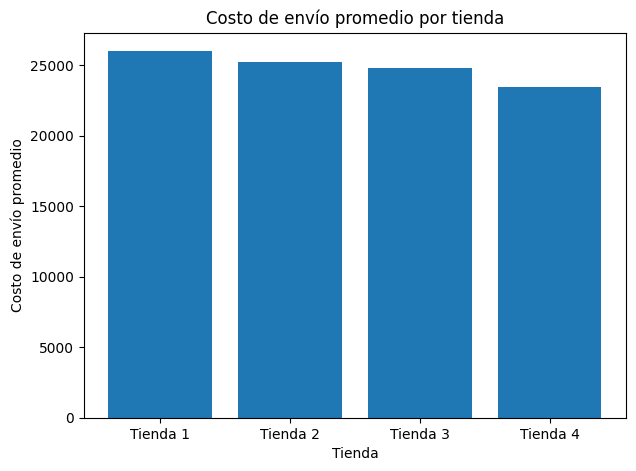

In [19]:
plt.figure(figsize=(7,5))
plt.bar(envio_prom["tienda"], envio_prom["envio_promedio"])
plt.title("Costo de envío promedio por tienda")
plt.xlabel("Tienda")
plt.ylabel("Costo de envío promedio")
plt.show()

# Visualizaciones finales

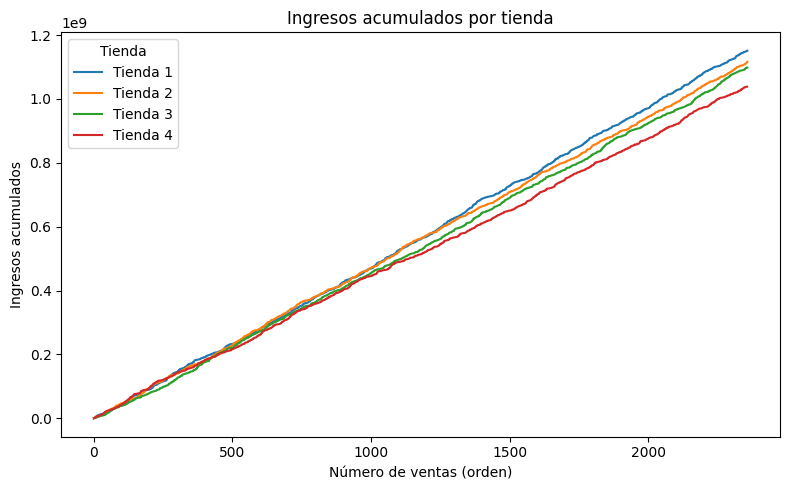

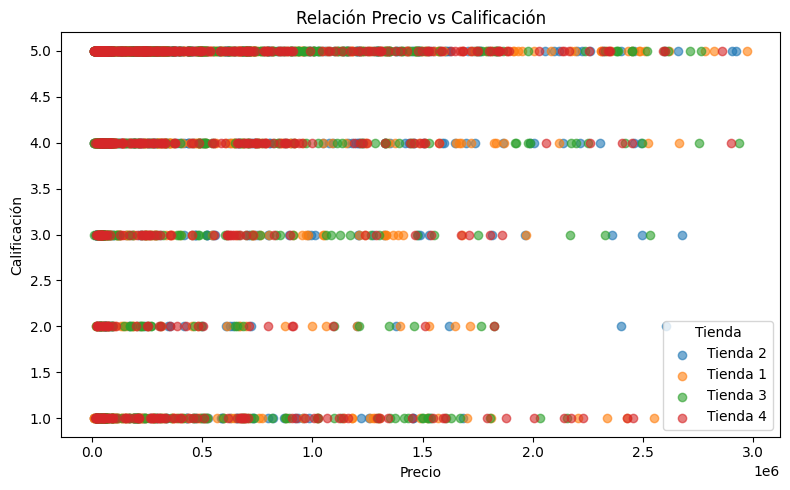

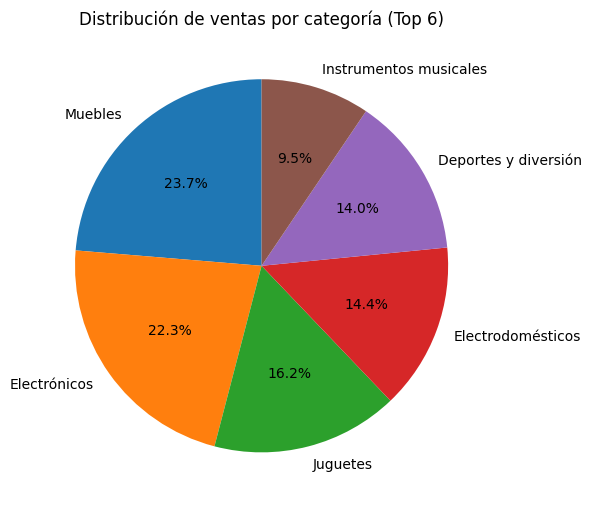

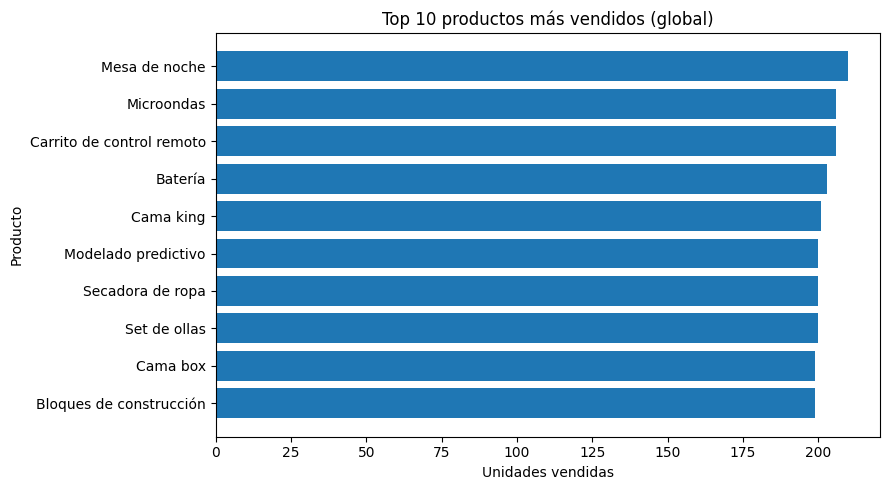

In [25]:
import os

# Crear carpeta 'imgs' si no existe
os.makedirs("imgs", exist_ok=True)

# 1) LÍNEAS: ingresos acumulados por tienda
df_all[COL_PRECIO] = pd.to_numeric(df_all[COL_PRECIO], errors="coerce")
ingresos_acum = (
    df_all.groupby("tienda")[COL_PRECIO]
    .cumsum()
    .reset_index()
)
plt.figure(figsize=(8,5))
for tienda in df_all["tienda"].unique():
    serie = ingresos_acum[df_all["tienda"] == tienda][COL_PRECIO]
    plt.plot(serie.values, label=tienda)
plt.title("Ingresos acumulados por tienda")
plt.xlabel("Número de ventas (orden)")
plt.ylabel("Ingresos acumulados")
plt.legend(title="Tienda")
plt.tight_layout()
plt.savefig("imgs/ingresos_acumulados.png", dpi=150, bbox_inches="tight")
plt.show()

# 2) DISPERSIÓN: Precio vs Calificación
df_all[COL_CALIF] = pd.to_numeric(df_all[COL_CALIF], errors="coerce")
muestra = df_all[[COL_PRECIO, COL_CALIF, "tienda"]].dropna()
if len(muestra) > 3000:  # para no saturar
    muestra = muestra.sample(3000, random_state=42)

plt.figure(figsize=(8,5))
for tienda in muestra["tienda"].unique():
    sub = muestra[muestra["tienda"]==tienda]
    plt.scatter(sub[COL_PRECIO], sub[COL_CALIF], alpha=0.6, label=tienda)
plt.title("Relación Precio vs Calificación")
plt.xlabel("Precio")
plt.ylabel("Calificación")
plt.legend(title="Tienda")
plt.tight_layout()
plt.savefig("imgs/dispersion_precio_calificacion.png", dpi=150, bbox_inches="tight")
plt.show()

# 3) PIE CHART: distribución de ventas por categoría (global)
ventas_cat_total = (
    df_all.groupby(COL_CAT)
    .size()
    .sort_values(ascending=False)
    .head(6)  # top 6 categorías
)
plt.figure(figsize=(6,6))
plt.pie(ventas_cat_total, labels=ventas_cat_total.index, autopct="%1.1f%%", startangle=90)
plt.title("Distribución de ventas por categoría (Top 6)")
plt.tight_layout()
plt.savefig("imgs/distribucion_categorias.png", dpi=150, bbox_inches="tight")
plt.show()

# 4) BARRAS HORIZONTALES: Top 10 productos global
ventas_prod_total = (
    df_all.groupby(COL_PROD)
    .size()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(9,5))
plt.barh(ventas_prod_total.index.astype(str), ventas_prod_total.values)
plt.title("Top 10 productos más vendidos (global)")
plt.xlabel("Unidades vendidas")
plt.ylabel("Producto")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("imgs/top_productos.png", dpi=150, bbox_inches="tight")
plt.show()


# Informe final

In [ ]:
import numpy as np
from functools import reduce

partes = []

# Ingresos
rev = df_all.groupby("tienda", as_index=False)[COL_PRECIO].sum().rename(columns={COL_PRECIO: "ingreso_total"})
partes.append(rev)

# Calificación
rat = df_all.groupby("tienda", as_index=False)[COL_CALIF].mean().rename(columns={COL_CALIF: "calificacion_promedio"})
partes.append(rat)

# Envío (si existe)
if COL_ENVIO in df_all.columns:
    shp = df_all.groupby("tienda", as_index=False)[COL_ENVIO].mean().rename(columns={COL_ENVIO: "envio_promedio"})
    partes.append(shp)

# Ventas totales (conteo de filas como proxy de unidades)
cnt = df_all.groupby("tienda", as_index=False).size().rename(columns={"size": "ventas_totales"})
partes.append(cnt)

# Top categoría por tienda (si existe)
if COL_CAT in df_all.columns:
    top_cat = (
        df_all.groupby(["tienda", COL_CAT]).size()
        .reset_index(name="ventas")
        .sort_values(["tienda","ventas"], ascending=[True, False])
        .groupby("tienda").head(1)
        .rename(columns={COL_CAT: "categoria_top"})
        .drop(columns=["ventas"])
    )
    partes.append(top_cat)

# Unir resumen
resumen = reduce(lambda L, R: pd.merge(L, R, on="tienda", how="left"), partes)
display(resumen)

# Heurística para tienda menos eficiente:
cand = resumen.copy()

for col in ["ingreso_total", "calificacion_promedio", "envio_promedio"]:
    if col in cand.columns:
        if col == "calificacion_promedio":
            cand[col] = cand[col].fillna(cand[col].mean())
        else:
            cand[col] = cand[col].fillna(cand[col].median())

# ranking: menos ingreso = peor, menor calificación = peor, mayor envío = peor
puntaje = pd.Series(0.0, index=cand.index)
if "ingreso_total" in cand:
    puntaje += cand["ingreso_total"].rank(ascending=True)
if "calificacion_promedio" in cand:
    puntaje += cand["calificacion_promedio"].rank(ascending=True)
if "envio_promedio" in cand:
    puntaje += cand["envio_promedio"].rank(ascending=False)

cand["puntaje_ineficiencia"] = puntaje
cand = cand.sort_values("puntaje_ineficiencia", ascending=True)
tienda_mas_debil = cand.iloc[0]["tienda"]


,tienda,ingreso_total,calificacion_promedio,envio_promedio,ventas_totales,categoria_top
0,Tienda 1,1.150880e+09,3.976685,26018.609580,2359,Muebles
1,Tienda 2,1.116344e+09,4.037304,25216.235693,2359,Muebles
2,Tienda 3,1.098020e+09,4.048326,24805.680373,2359,Muebles
3,Tienda 4,1.038376e+09,3.995759,23459.457167,2358,Muebles


# **Informe final — Alura Store**


**Objetivo:** Analizar desempeño de las 4 tiendas y recomendar cuál vender, considerando ingresos, categorías, calificaciones, productos y costo de envío.

**Resumen por tienda:**

In [22]:
lineas = []
for _, r in resumen.iterrows():
    fila = f"- {r['tienda']}: "
    if 'ingreso_total' in r and not pd.isna(r['ingreso_total']):
        fila += f"Ingresos={r['ingreso_total']:.2f} | "
    if 'calificacion_promedio' in r and not pd.isna(r['calificacion_promedio']):
        fila += f"Calificación={r['calificacion_promedio']:.2f} | "
    if 'envio_promedio' in r and not pd.isna(r.get('envio_promedio', np.nan)):
        fila += f"EnvíoProm={r['envio_promedio']:.2f} | "
    if 'categoria_top' in r and isinstance(r['categoria_top'], str):
        fila += f"CategoríaTop={r['categoria_top']} | "
    fila = fila.rstrip(" | ")
    lineas.append(fila)
print("\n".join(lineas))

- Tienda 1: Ingresos=1150880400.00 | Calificación=3.98 | EnvíoProm=26018.61 | CategoríaTop=Muebles
- Tienda 2: Ingresos=1116343500.00 | Calificación=4.04 | EnvíoProm=25216.24 | CategoríaTop=Muebles
- Tienda 3: Ingresos=1098019600.00 | Calificación=4.05 | EnvíoProm=24805.68 | CategoríaTop=Muebles
- Tienda 4: Ingresos=1038375700.00 | Calificación=4.00 | EnvíoProm=23459.46 | CategoríaTop=Muebles


**Recomendación:**



In [23]:
print(f"Se sugiere considerar la venta de {tienda_mas_debil}. ")

Se sugiere considerar la venta de Tienda 1. 


Esta decisión se sustenta en su menor desempeño relativo en la combinación de ingresos, calificación promedio y eficiencia logística (costo de envío), comparada con las demás tiendas.

**Justificación:**

- **Ingresos**: la facturación es el principal indicador de desempeño comercial.  
- **Calificaciones**: reflejan satisfacción del cliente y probabilidad de recompra.  
- **Costos de envío**: impactan margen y experiencia del cliente.  
Si se decide optimizar en lugar de vender, priorizar:  
1. Renegociar tarifas de envío  
2. Depurar productos de baja rotación  
3. Mejorar la atención al cliente para elevar reseñas  
